In [27]:
# pip install prody torch torch_geometric numpy scipy
from typing import Dict, List, Tuple, Optional
import numpy as np
from scipy.spatial import cKDTree

import prody as pr
import torch
from torch_geometric.data import HeteroData


In [28]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [29]:

AA_THREE_TO_ONE = {
	'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLN':'Q','GLU':'E','GLY':'G',
	'HIS':'H','ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S',
	'THR':'T','TRP':'W','TYR':'Y','VAL':'V','SEC':'U','PYL':'O'
}

# Basic chemistry lists (tweak as needed)
NEGATIVE = {'ASP','GLU'}
POSITIVE = {'ARG','LYS','HIS'}
AROMATIC = {'PHE','TYR','TRP','HIS'}

def residue_key(res):
	"""Stable residue key: (chainID, resnum, icode)."""
	return (res.getChid(), int(res.getResnum()), (res.getIcode() or '').strip())

def one_letter(resname: str) -> str:
	return AA_THREE_TO_ONE.get(resname.upper(), 'X')

# ---------------------------
# ProDy → residue graph
# ---------------------------


In [30]:

def load_structure(pdb_path: str,
				   model_index: int = 0,
				   atomsel: str = 'protein and not altloc B-Z') -> pr.AtomGroup:
	res = pr.addMissingAtoms(pdb_path, method='openbabel')
	print(res)
	ag = pr.parsePDB(res)

	#ag.addMissingAtoms()
	atoms = ag.select('protein')
	return atoms
# ---------------------------
# Interaction detection
# ---------------------------
def get_interaction_object(ag: pr.AtomGroup ) -> pr.Interactions:
	interactions = pr.Interactions()
	all_interactions = interactions.calcProteinInteractions(ag)
	return all_interactions , interactions

def interaction_matrix_energy(ag):
	return pr.Interactions.buildInteractionMatrixEnergy(ag)


In [35]:
#load structure and get interactions
ag = load_structure('./tmp/U1Y2K4.pdb')
interactionlist, interactionobj = get_interaction_object(ag)

@> WARNING outfile ./tmp/addH_U1Y2K4.pdb already exists, so returning it. Set overwrite=True to overwrite it
@> 2970 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Calculating interactions.
@> Calculating hydrogen bonds.


./tmp/addH_U1Y2K4.pdb


@>      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
@>       TYR4    A         OH_27  <--->      GLU37    A       OE2_293     2.5    38.1
@>     GLY120    A         N_931  <--->     ILE136    A        O_1072     2.7    21.4
@>     LYS165    A        N_1290  <--->     LYS174    A        O_1363     2.8    39.9
@>     LEU108    A         N_837  <--->     LEU144    A        O_1131     2.8     5.9
@>     GLN137    A        N_1076  <--->     THR145    A        O_1139     2.8    30.1
@>     ILE159    A        N_1246  <--->      ALA93    A         O_735     2.8     9.3
@>     LYS154    A       NZ_1219  <--->     ASP128    A       OD1_999     2.8    25.2
@>     VAL134    A        N_1054  <--->     ALA123    A         O_957     2.8     7.6
@>      ALA93    A         N_731  <--->     ILE159    A        O_1250     2.8    14.3
@>     GLN150    A        N_1176  <--->     GLU132    A      OE2_1044     2.8    12.3
@>     LEU149    A        N_1168  <--->     SER102  

In [36]:
ematrix = interactionobj.buildInteractionMatrixEnergy()#energy_list_type='CS' )

@> Calculating interaction energies matrix with type IB_solv


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


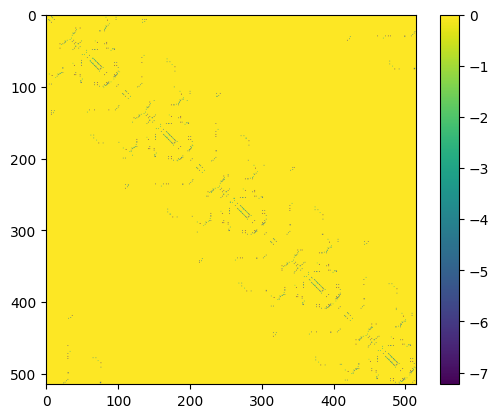

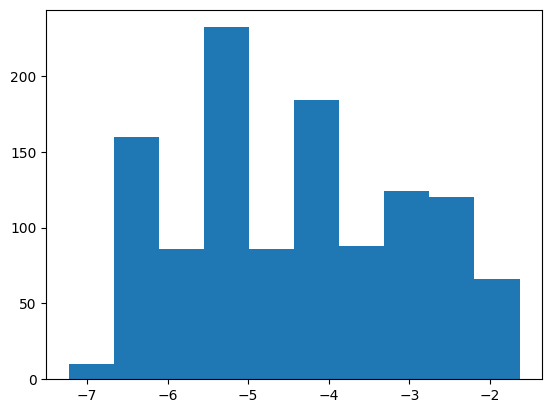

In [26]:
print(ematrix)
plt.imshow(ematrix)
plt.colorbar()
plt.show()
plt.hist(ematrix.flatten()[ np.abs(ematrix.flatten()) > 0], bins=10)
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


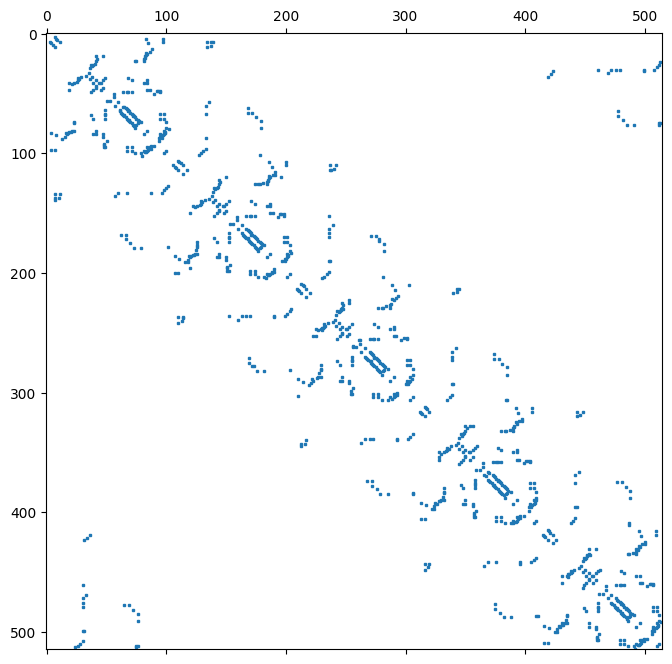

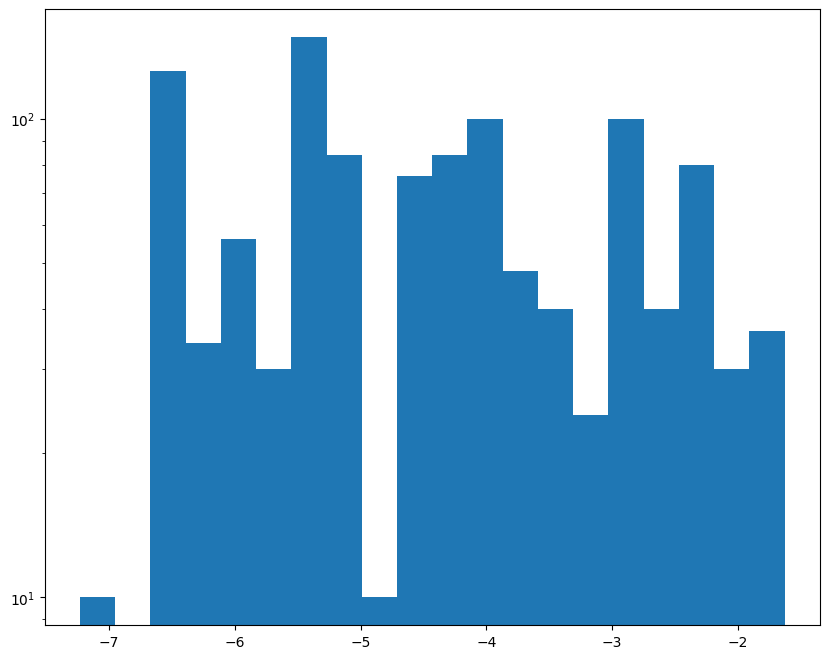

In [9]:
print(ematrix)
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.spy(ematrix , markersize=2	)

plt.show()

plt.figure(figsize=(10,8))
#histogram of non zero values
plt.hist(ematrix[ematrix!=0].flatten(), bins=20	)
plt.yscale('log')
plt.show()

@> Calculating interaction matrix


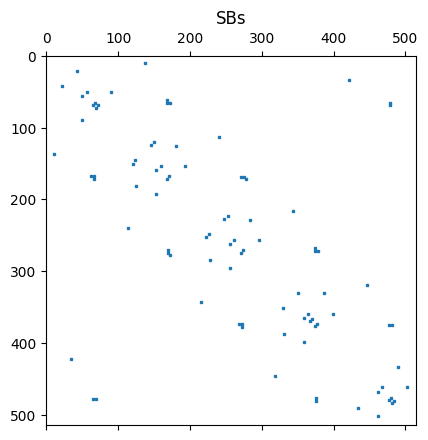

@> Calculating interaction matrix


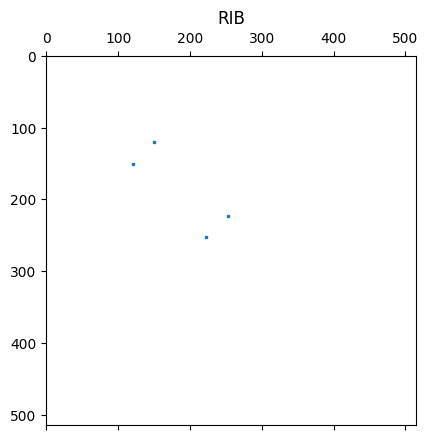

@> Calculating interaction matrix


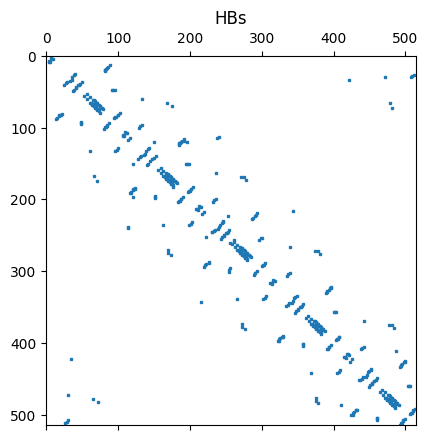

@> Calculating interaction matrix


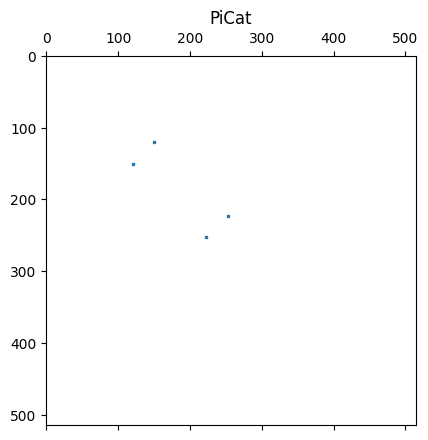

@> Calculating interaction matrix


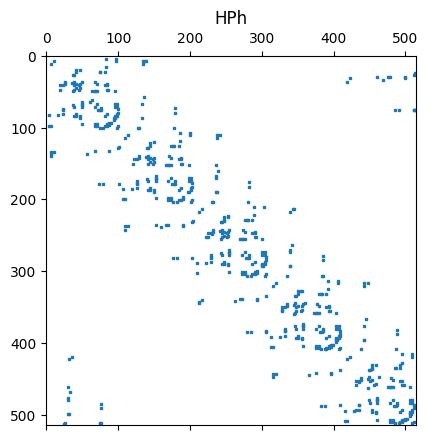

@> Calculating interaction matrix


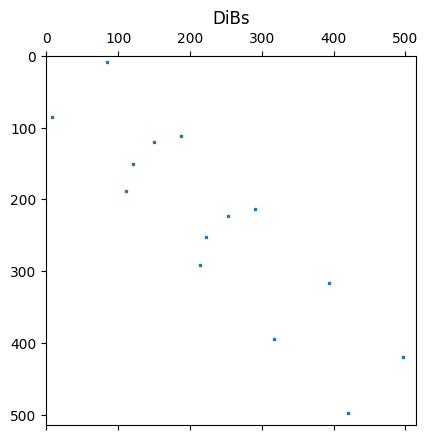

In [10]:
# loop through interactions types and show energy matrices
types = ['SBs' , 'RIB', 'HBs','PiCat', 'HPh', 'DiBs']
stack = []
for t in types:
	#zero out all but one type
	params = {tp:0 for tp in types}
	params[t] = 1
	matrix = interactionobj.buildInteractionMatrix(**params)
	stack.append(matrix)
	plt.figure()
	plt.title(t)
	plt.spy(matrix , markersize=2)
	plt.show()

@> Hessian was built in 0.22s.
@> 20 modes were calculated in 0.31s.
@> Calculating stiffness matrix.
@> Stiffness matrix calculated in 0.04s.
@> The range of effective force constant is: 1.3356578713622225 to 3.0043886872988783.
/tmp/ipykernel_44405/823159508.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(stiffness) , cmap='jet_r')


[[0.         2.30966204 2.49514047 ... 2.23296736 2.12094886 1.98618861]
 [2.30966204 0.         2.2726863  ... 2.13710432 2.0400553  1.94165504]
 [2.49514047 2.2726863  0.         ... 2.03645931 1.96699216 1.8946146 ]
 ...
 [2.23296736 2.13710432 2.03645931 ... 0.         2.22426802 2.26524241]
 [2.12094886 2.0400553  1.96699216 ... 2.22426802 0.         2.30362312]
 [1.98618861 1.94165504 1.8946146  ... 2.26524241 2.30362312 0.        ]]


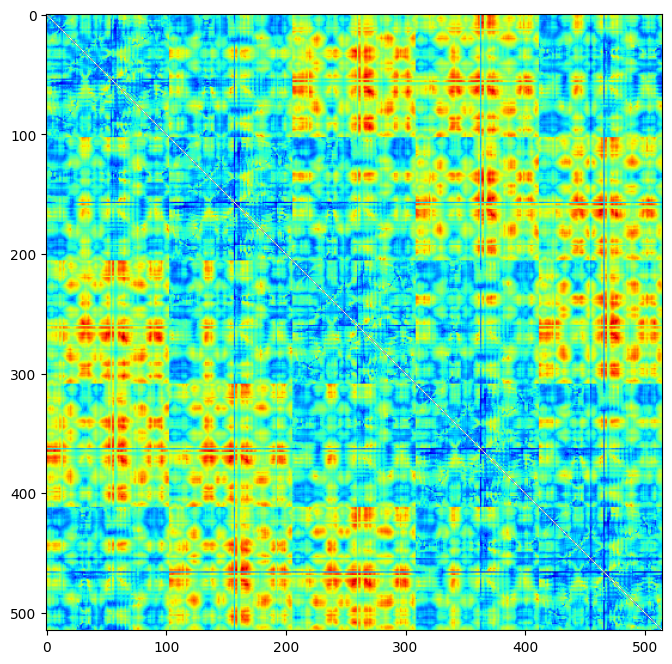

In [11]:
alphas = ag.ca
anm = pr.ANM('ANM analysis')
anm.buildHessian(alphas)
anm.calcModes(n_modes=20)
stiffness = pr.calcMechStiff(anm, alphas)
print(stiffness)
#show = pr.showMechStiff(stiffness, alphas, cmap='jet_r')
plt.figure(figsize=(10,8))
plt.imshow( np.log(stiffness) , cmap='jet_r')
plt.show()

In [ ]:


from scipy.sparse import csr_matrix

def structure_to_heterodata(pdb_path: str, 
						   model_index: int = 0,
						   interaction_types: List[str] = ['SBs', 'RIB', 'HBs', 'PiCat', 'HPh', 'DiBs']) -> HeteroData:
	"""
	Load a protein structure and compile interaction matrices into a PyTorch Geometric HeteroData object.
	
	Args:
		pdb_path: Path to PDB file
		model_index: Model index to use
		interaction_types: List of interaction types to include
		
	Returns:
		HeteroData object with residue nodes and interaction edges
	"""
	# Load structure
	ag = load_structure(pdb_path, model_index)
	
	# Get interactions
	interactionlist, interactionobj = get_interaction_object(ag)
	
	# Get CA atoms (one per residue)
	ca_atoms = ag.ca
	n_residues = len(ca_atoms)
	
	# Initialize HeteroData
	data = HeteroData()
	
	# Add residue node features
	# Get residue names and convert to one-letter codes
	residue_names = [one_letter(res.getResname()) for res in ca_atoms.iterResidues()]
	
	# Create node features (can be extended with more features)
	# For now, using residue coordinates as features
	coords = ca_atoms.getCoords()
	data['res'].x = torch.tensor(coords, dtype=torch.float)
	data['res'].residue_names = residue_names
	
	# Add interaction edges for each type
	for interaction_type in interaction_types:
		# Build interaction matrix for this type
		params = {tp: 0 for tp in interaction_types}
		params[interaction_type] = 1
		matrix = interactionobj.buildInteractionMatrix(**params)
		
		# Convert to scipy sparse matrix
		sparse_matrix = csr_matrix(matrix)
		
		# Get edge indices from sparse matrix (only non-zero entries)
		edge_indices = sparse_matrix.nonzero()
		
		if len(edge_indices[0]) > 0:
			# Create edge index tensor
			edge_index = torch.tensor(np.array(edge_indices), dtype=torch.long)
			
			# Get edge weights (interaction strengths) from sparse matrix
			edge_weights = sparse_matrix.data
			edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)
			
			# Add to HeteroData
			data['res', interaction_type, 'res'].edge_index = edge_index
			data['res', interaction_type, 'res'].edge_attr = edge_attr
	
	return data